Sube el archivo Excel de Nestle 1d


Saving Nestle 1d.xlsx to Nestle 1d (3).xlsx
Datos cargados para Nestle 1d: 508 filas
Sube el archivo Excel de IBM 1d


Saving IBM 1d.xlsx to IBM 1d (1).xlsx
Datos cargados para IBM 1d: 877 filas
Sube el archivo Excel de Arca 1d


Saving Arca 1d.xlsx to Arca 1d (1).xlsx
Datos cargados para Arca 1d: 398 filas
Sube el archivo Excel de Nestle 5min


Saving Nestle 5min.xlsx to Nestle 5min (1).xlsx
Datos cargados para Nestle 5min: 208 filas
Sube el archivo Excel de IBM 5min


Saving IBM 5min.xlsx to IBM 5min (1).xlsx
Datos cargados para IBM 5min: 381 filas
Sube el archivo Excel de Arca 5min


Saving Arca 5min.xlsx to Arca 5min (1).xlsx
Datos cargados para Arca 5min: 169 filas

Resumen Nestle 1d: count    498.000000
mean      90.223775
std        0.350747
min       89.600000
25%       89.980000
50%       90.080000
75%       90.515000
max       91.020000
Name: Close, dtype: float64

Resumen IBM 1d: count    726.000000
mean     260.297626
std        2.792236
min      254.741900
25%      257.410000
50%      260.005050
75%      262.997500
max      265.760000
Name: Close, dtype: float64

Resumen Arca 1d: count    390.000000
mean     206.686923
std        0.753610
min      205.150000
25%      206.110000
50%      206.750000
75%      207.117500
max      209.310000
Name: Close, dtype: float64

Resumen Nestle 5min: count    203.000000
mean      89.415271
std        0.919098
min       87.900000
25%       88.520000
50%       89.720000
75%       90.080000
max       90.980000
Name: Close, dtype: float64

Resumen IBM 5min: count    357.000000
mean     257.379707
std        5.146619
min    

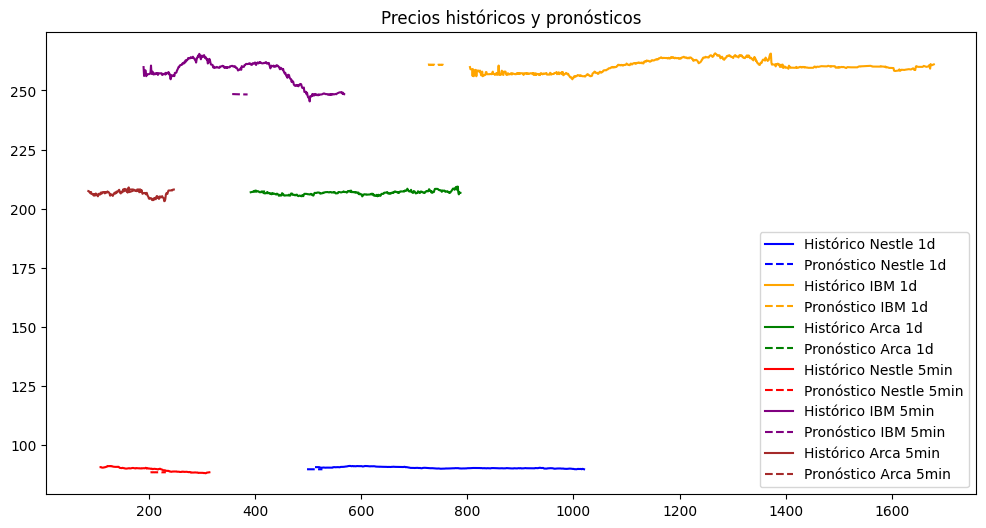

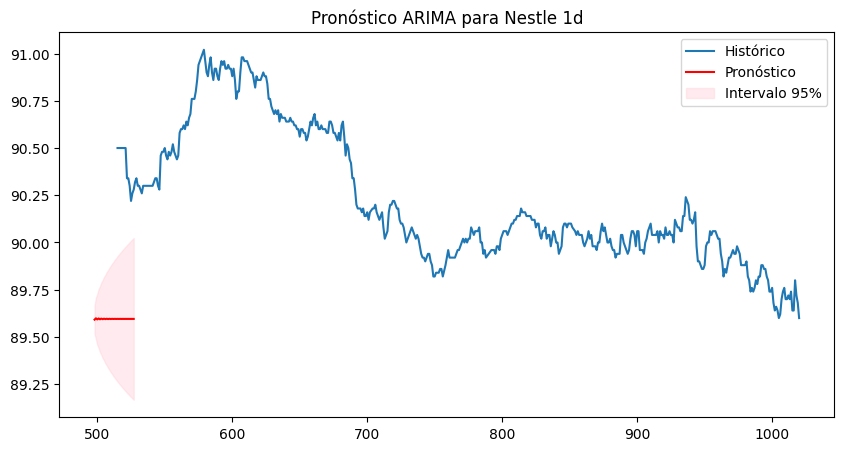

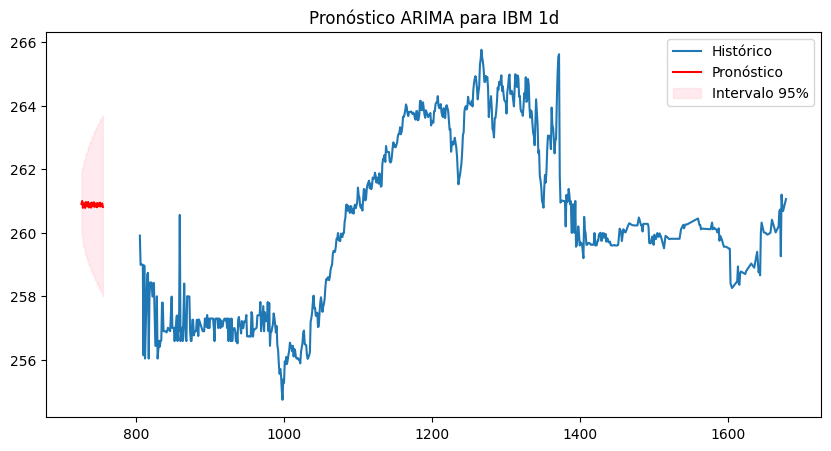

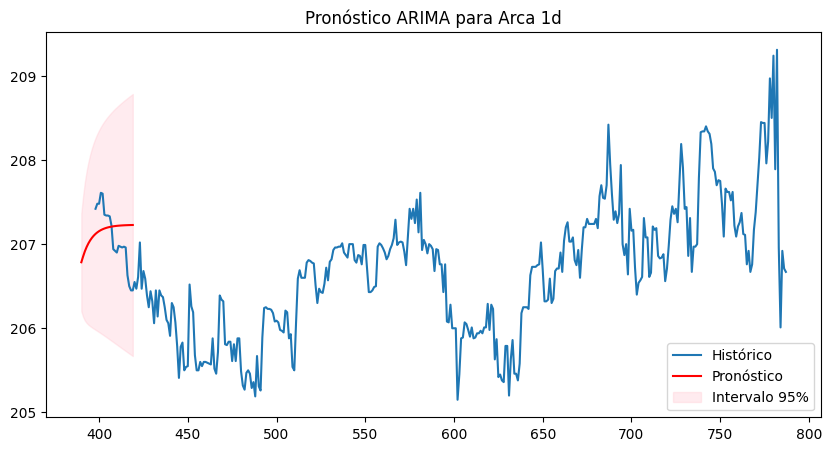

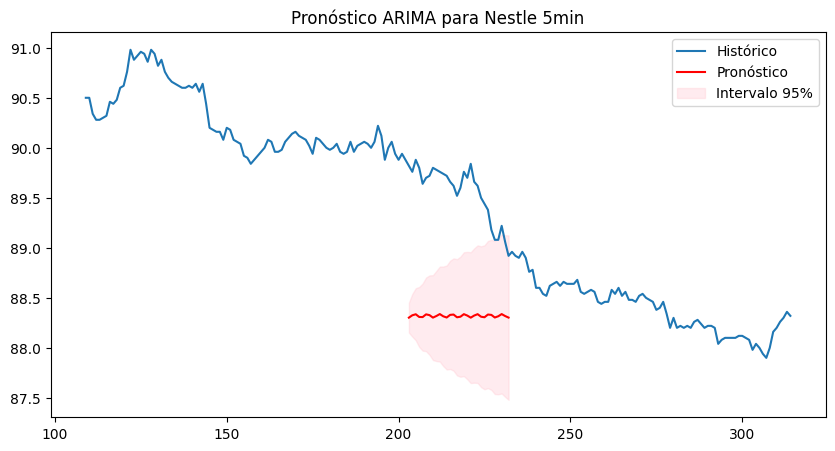

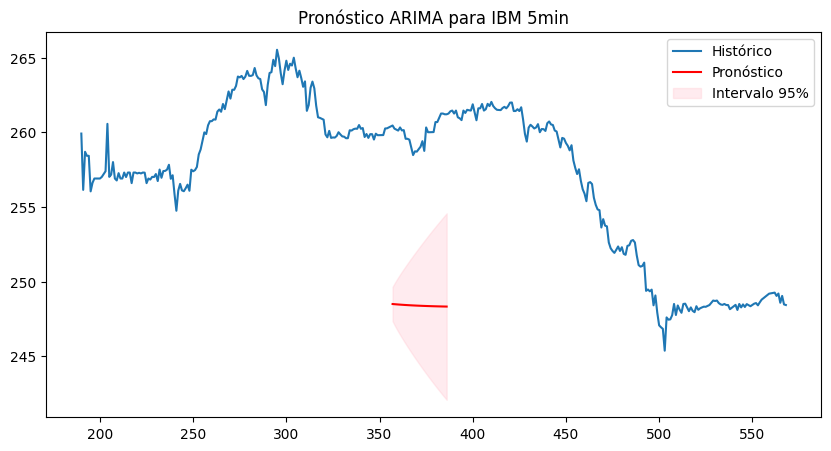

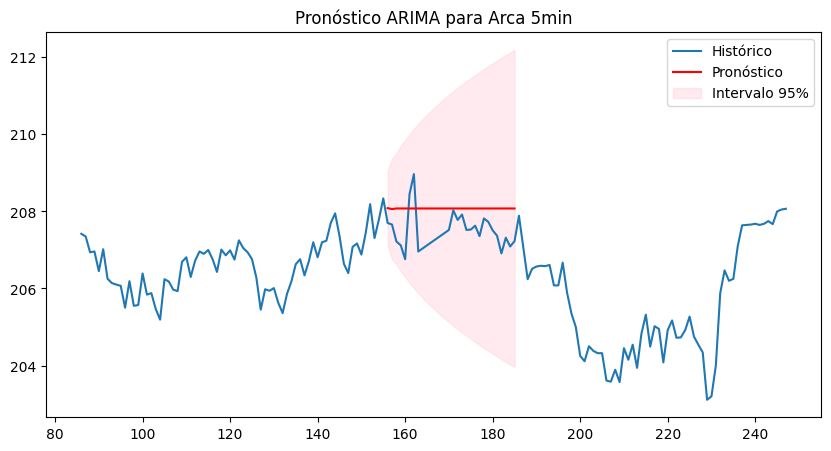

In [18]:
import pandas as pd
import numpy as np
from google.colab import files
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Lista de activos con nombres ajustados a tus archivos
activos = [
    "Nestle 1d", "IBM 1d", "Arca 1d",      # 1 minuto, 10-11 Mar 25
    "Nestle 5min", "IBM 5min", "Arca 5min" # 5 minutos, 7-11 Mar 25
]

# Rangos de fechas esperados
fechas = {
    "1d": (pd.Timestamp("2025-03-10"), pd.Timestamp("2025-03-11")),
    "5min": (pd.Timestamp("2025-03-07"), pd.Timestamp("2025-03-11"))
}

# Cargar y filtrar datos
dataframes = {}
for activo in activos:
    print(f"Sube el archivo Excel de {activo}")
    upload = files.upload()
    filename = list(upload.keys())[0]
    df = pd.read_excel(filename)

    # Usar 'Local Date' como columna de fechas
    df['Local Date'] = pd.to_datetime(df['Local Date'])
    marco = "1d" if "1d" in activo else "5min"
    df = df[(df['Local Date'] >= fechas[marco][0]) & (df['Local Date'] <= fechas[marco][1])]
    if df.empty:
        raise ValueError(f"No hay datos en el rango de fechas para {activo}")
    dataframes[activo] = df
    print(f"Datos cargados para {activo}: {len(df)} filas")

# Usar 'Close' como columna de precios de cierre
columna_cierre = "Close"
series_dict = {}
for activo in activos:
    if columna_cierre not in dataframes[activo].columns:
        print(f"Columnas disponibles en {activo}: {list(dataframes[activo].columns)}")
        raise ValueError(f"No se encontró la columna 'Close' en {activo}")
    series_dict[activo] = dataframes[activo][columna_cierre].dropna()
    print(f"\nResumen {activo}: {series_dict[activo].describe()}")

# Pruebas de raíz unitaria y estacionariedad
def unit_root_tests(series, name):
    print(f"\nPruebas para {name}:")
    adf_result = adfuller(series)
    print(f"ADF: p-valor = {adf_result[1]:.4f}")
    print(" - Estacionario" if adf_result[1] < 0.05 else " - No estacionario (raíz unitaria)")
    kpss_result = kpss(series, regression='c')
    print(f"KPSS: p-valor = {kpss_result[1]:.4f}")
    print(" - Estacionario" if kpss_result[1] >= 0.05 else " - No estacionario")
for activo in activos:
    unit_root_tests(series_dict[activo], activo)

# Ajuste ARIMA completo
def find_best_arima(series, name, max_p=3, max_d=2, max_q=3):
    mejor_aic = float('inf')
    mejor_orden = None
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    modelo = ARIMA(series, order=(p, d, q))
                    resultados = modelo.fit()
                    if resultados.aic < mejor_aic:
                        mejor_aic = resultados.aic
                        mejor_orden = (p, d, q)
                except Exception as e:
                    print(f"Error ajustando ARIMA({p},{d},{q}) para {name}: {e}")
                    continue
    if mejor_orden is None:
        print(f"No se encontró modelo para {name}, usando (1,1,1) por defecto")
        mejor_orden = (1, 1, 1)
    else:
        print(f"Mejor ARIMA para {name}: {mejor_orden}, AIC = {mejor_aic:.2f}")
    return mejor_orden

# Modelos y pronósticos
modelos = {}
pronosticos = {}
pasos_pronostico = 30  # Ajusta según necesidad (ej. 60 para 1d, 150 para 5min)
for activo in activos:
    orden = find_best_arima(series_dict[activo], activo)
    modelos[activo] = ARIMA(series_dict[activo], order=orden).fit()
    pronosticos[activo] = modelos[activo].forecast(steps=pasos_pronostico)
    print(f"Resumen del modelo para {activo}:\n{modelos[activo].summary()}")

# Comparación entre las 6 series
print("\nComparación entre las series:")
combined_df = pd.DataFrame(series_dict)
correlaciones = combined_df.corr()
print("Matriz de correlaciones:")
print(correlaciones)

# Métricas de pronósticos
for activo in activos:
    ultimo_valor = series_dict[activo].iloc[-1]
    pronostico_promedio = pronosticos[activo].mean()
    print(f"\n{activo}: Último valor = {ultimo_valor:.2f}, Pronóstico promedio = {pronostico_promedio:.2f}")
    print("Tendencia:" + (" Al alza" if pronostico_promedio > ultimo_valor else " A la baja" if pronostico_promedio < ultimo_valor else " Estable"))

# Gráficos de históricos y pronósticos
plt.figure(figsize=(12, 6))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
for i, activo in enumerate(activos):
    plt.plot(series_dict[activo], label=f'Histórico {activo}', color=colors[i])
    indice_pronostico = range(len(series_dict[activo]), len(series_dict[activo]) + pasos_pronostico)
    plt.plot(indice_pronostico, pronosticos[activo], label=f'Pronóstico {activo}', color=colors[i], linestyle='--')
plt.title('Precios históricos y pronósticos')
plt.legend()
plt.show()

# Gráficos individuales con intervalos de confianza
for activo in activos:
    forecast_obj = modelos[activo].get_forecast(steps=pasos_pronostico)
    pronostico = forecast_obj.predicted_mean
    intervalo_conf = forecast_obj.conf_int()
    indice_pronostico = range(len(series_dict[activo]), len(series_dict[activo]) + pasos_pronostico)

    plt.figure(figsize=(10, 5))
    plt.plot(series_dict[activo], label='Histórico')
    plt.plot(indice_pronostico, pronostico, label='Pronóstico', color='red')
    plt.fill_between(indice_pronostico, intervalo_conf.iloc[:, 0], intervalo_conf.iloc[:, 1],
                     color='pink', alpha=0.3, label='Intervalo 95%')
    plt.title(f'Pronóstico ARIMA para {activo}')
    plt.legend()
    plt.show()